# Round 2

## Importing libraries

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# Loading the data 
data = pd.read_csv('marketing_customer_analysis.csv')

In [3]:
# 1. Show the dataframe shape.
data.shape

(10910, 26)

In [4]:
# 2. Standardize header names.
data.columns = [e.lower().replace(' ', '_') for e in data.columns]
# data.head()

In [5]:
# Which columns are numerical?
data.select_dtypes(include= np.number).columns

Index(['unnamed:_0', 'customer_lifetime_value', 'income',
       'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'total_claim_amount'],
      dtype='object')

In [6]:
# Which columns are categorical?
data.select_dtypes(include= object).columns

Index(['customer', 'state', 'response', 'coverage', 'education',
       'effective_to_date', 'employmentstatus', 'gender', 'location_code',
       'marital_status', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type'],
      dtype='object')

## Check and deal with NaN values.

In [7]:
# Checking which columns have NaN values.
data.isna().sum()

unnamed:_0                          0
customer                            0
state                             631
customer_lifetime_value             0
response                          631
coverage                            0
education                           0
effective_to_date                   0
employmentstatus                    0
gender                              0
income                              0
location_code                       0
marital_status                      0
monthly_premium_auto                0
months_since_last_claim           633
months_since_policy_inception       0
number_of_open_complaints         633
number_of_policies                  0
policy_type                         0
policy                              0
renew_offer_type                    0
sales_channel                       0
total_claim_amount                  0
vehicle_class                     622
vehicle_size                      622
vehicle_type                     5482
dtype: int64

In [8]:
# Checking the head, we see that unnamed:_0 and customer are kinda useless for further analysis (unique values)
display(data.head())

# So better drop those straight away - like it's hot
data = data.drop(['unnamed:_0', 'customer'], axis=1)

,unnamed:_0,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type
0,0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN


In [9]:
# Also checking which are duplicates eitherway

print('We have', data.duplicated().sum(),'duplicates in the dataframe')
print('The shape before dropping duplicates is this:', data.shape)

We have 134 duplicates in the dataframe
The shape before dropping duplicates is this: (10910, 24)


In [10]:
# And subsequently, dropping those

data = data.drop_duplicates(keep='first')
print('Looks like our data went on a diet - shape is getting tighter:', data.shape)

Looks like our data went on a diet - shape is getting tighter: (10776, 24)


In [11]:
# Checking the percentage of null values to make an informed decision of what to do with those values

round(data.isna().sum()/len(data),4)*100  # shows the percentage of null values in a column
nulls_df = pd.DataFrame(round(data.isna().sum()/len(data),4)*100)
nulls_df = nulls_df.reset_index()
nulls_df.columns = ['header_name', 'percent_nulls']
nulls_df

,header_name,percent_nulls
0,state,5.69
1,customer_lifetime_value,0.00
2,response,5.69
3,coverage,0.00
4,education,0.00
5,effective_to_date,0.00
6,employmentstatus,0.00
7,gender,0.00
8,income,0.00
9,location_code,0.00


Looks like 50% of vehicle type is missing either way, so imputing it with the most common vehicle type will likely scew the data too much because there is only one value. Going to impute it with "M" for manual, because "A" is likely for automatic - we're talking about cars after all.

State, response, months since last claim, number of open complaints, vehicle class and vehicle size are still below 6% of missings, dropping those nA's would be a loss of valuable data so better impute it with the most common value for categorial data and the mean for the numericals.

### So here we go:

In [13]:
# First, filling NaN of vehicle_type with "M"
data['vehicle_type'] = data['vehicle_type'].fillna('M')
data['vehicle_type'].unique()

array(['M', 'A'], dtype=object)

In [28]:
# Filling NaN's of numerical variables with their mean:

mean_months_since_last_claim = data['months_since_last_claim'].mean()
mean_months_since_last_claim
data['months_since_last_claim'] = data['months_since_last_claim'].fillna(mean_months_since_last_claim)

In [30]:
mean_number_of_open_complaints = data['number_of_open_complaints'].mean()
mean_number_of_open_complaints
data['number_of_open_complaints'] = data['number_of_open_complaints'].fillna(mean_number_of_open_complaints)

In [15]:
# Imputing NaN's of categorical with their most common value:

data['state'].value_counts(dropna=False)

California    3512
Oregon        2861
Arizona       1918
Nevada         987
Washington     885
NaN            613
Name: state, dtype: int64

In [16]:
# Using most common value of variable "state" to fill NaN
data['state'] = data['state'].fillna('California')
len(data[data['state'].isna()==True]) # now this number is 0
data['state'].value_counts(dropna=False)

California    4125
Oregon        2861
Arizona       1918
Nevada         987
Washington     885
Name: state, dtype: int64

In [18]:
# Same for the rest of categoricals with NaN, response:

data['response'].value_counts(dropna=False)

No     8795
Yes    1368
NaN     613
Name: response, dtype: int64

In [19]:
data['response'] = data['response'].fillna('No')
len(data[data['response'].isna()==True]) # now this number is 0
data['response'].value_counts(dropna=False)

No     9408
Yes    1368
Name: response, dtype: int64

In [21]:
# For "vehicle class":

data['vehicle_class'].value_counts(dropna=False)

Four-Door Car    5151
Two-Door Car     2093
SUV              1992
NaN               608
Sports Car        540
Luxury SUV        205
Luxury Car        187
Name: vehicle_class, dtype: int64

In [23]:
data['vehicle_class'] = data['vehicle_class'].fillna('Four-Door Car')
len(data[data['vehicle_class'].isna()==True]) # now this number is 0
data['vehicle_class'].value_counts(dropna=False)

Four-Door Car    5759
Two-Door Car     2093
SUV              1992
Sports Car        540
Luxury SUV        205
Luxury Car        187
Name: vehicle_class, dtype: int64

In [25]:
# For "vehicle size":

data['vehicle_size'].value_counts(dropna=False)

Medsize    7160
Small      1947
Large      1061
NaN         608
Name: vehicle_size, dtype: int64

In [27]:
data['vehicle_size'] = data['vehicle_size'].fillna('Medsize')
len(data[data['vehicle_size'].isna()==True]) # now this number is 0
data['vehicle_size'].value_counts(dropna=False)

Medsize    7768
Small      1947
Large      1061
Name: vehicle_size, dtype: int64

#### Now we should have 0 null values but better to check again:

In [31]:
round(data.isna().sum()/len(data),4)*100  # shows the percentage of null values in a column
nulls_df = pd.DataFrame(round(data.isna().sum()/len(data),4)*100)
nulls_df = nulls_df.reset_index()
nulls_df.columns = ['header_name', 'percent_nulls']
nulls_df

,header_name,percent_nulls
0,state,0.0
1,customer_lifetime_value,0.0
2,response,0.0
3,coverage,0.0
4,education,0.0
5,effective_to_date,0.0
6,employmentstatus,0.0
7,gender,0.0
8,income,0.0
9,location_code,0.0


#### Looks like we achieved the aim - nice

In [ ]:
# Datetime format - Extract the months from the dataset and store in a separate column. 
# Then filter the data to show only the information for the first quarter , ie. January, February and March. 
# Hint: If data from March does not exist, consider only January and February.

In [33]:
data['effective_to_date'] = pd.to_datetime(data['effective_to_date'], errors='coerce')

data['month'] = pd.DatetimeIndex(data['effective_to_date']).month
data['month'].unique()

# Looks like everything is either January or February

array([2, 1], dtype=int64)

In [ ]:
# Just for fun, this would be the code to filter for the first quarter without even needing to add the month column:

# data_quarterone = data[data['effective to date'].dt.quarter == 1]

### Function to clean dataframe

... Which is basically kinda the steps above but in a function, so won't execute it again since I already did those steps outside of the function

In [ ]:
def clean_data(df):
    
    # Standarize column names:
    df.columns = [e.lower().replace(' ', '_') for e in df.columns]
    
    # Drop those unneeded columns:
    df = df.drop(columns=['unnamed:_0', 'customer'])
    
    # Impute
    df['vehicle_type']=df['vehicle type'].fillna('M')
    
    mean_months_since_last_claim = data['months_since_last_claim'].mean()
    data['months_since_last_claim'] = data['months_since_last_claim'].fillna(mean_months_since_last_claim)
    
    mean_number_of_open_complaints = data['number_of_open_complaints'].mean()
    data['number_of_open_complaints'] = data['number_of_open_complaints'].fillna(mean_number_of_open_complaints)
    
    data['state'] = data['state'].fillna('California')
    data['state'].value_counts(dropna=False)
    
    data['response'] = data['response'].fillna('No')
    data['response'].value_counts(dropna=False)
    
    data['vehicle_class'] = data['vehicle_class'].fillna('Four-Door Car')
    data['vehicle_class'].value_counts(dropna=False)
    
    data['vehicle_size'] = data['vehicle_size'].fillna('Medsize')
    data['vehicle_size'].value_counts(dropna=False)
    
    # Put variable 'effective_to_date' into datetime dtype and create column for month
    df['effective_to_date']=pd.to_datetime(df['effective_to_date'], errors='coerce')
    df['month'] = df['effective_to_date'].dt.month
    
    
    
    return df

One last check, how does our data look after all of this?

In [35]:
display(data.head())
print(data.columns)

,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,...,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type,month
0,Arizona,4809.216960,No,Basic,College,2011-02-18,Employed,M,48029,Suburban,...,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,M,2
1,California,2228.525238,No,Basic,College,2011-01-18,Unemployed,F,0,Suburban,...,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,M,1
2,Washington,14947.917300,No,Basic,Bachelor,2011-02-10,Employed,M,22139,Suburban,...,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A,2
3,Oregon,22332.439460,Yes,Extended,College,2011-01-11,Employed,M,49078,Suburban,...,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A,1
4,Oregon,9025.067525,No,Premium,Bachelor,2011-01-17,Medical Leave,F,23675,Suburban,...,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,M,1


Index(['state', 'customer_lifetime_value', 'response', 'coverage', 'education',
       'effective_to_date', 'employmentstatus', 'gender', 'income',
       'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size', 'vehicle_type', 'month'],
      dtype='object')


# Round 3

## Exploratory Data Analysis

In [36]:
# Show DataFrame info.

data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10776 entries, 0 to 10909
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   state                          10776 non-null  object        
 1   customer_lifetime_value        10776 non-null  float64       
 2   response                       10776 non-null  object        
 3   coverage                       10776 non-null  object        
 4   education                      10776 non-null  object        
 5   effective_to_date              10776 non-null  datetime64[ns]
 6   employmentstatus               10776 non-null  object        
 7   gender                         10776 non-null  object        
 8   income                         10776 non-null  int64         
 9   location_code                  10776 non-null  object        
 10  marital_status                 10776 non-null  object        
 11  monthly_premium

In [37]:
# Describe DataFrame.

data.describe()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month
count,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000
mean,8016.710885,37543.735152,93.200260,15.146952,48.120638,0.383926,2.979306,434.759809,1.467613
std,6885.053012,30397.579910,34.408721,9.781951,27.928243,0.884172,2.398228,292.452845,0.498973
min,1898.007675,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.099007,1.000000
25%,4014.453113,0.000000,68.000000,7.000000,24.000000,0.000000,1.000000,270.290316,1.000000
50%,5774.709107,33837.000000,83.000000,15.000000,48.000000,0.000000,2.000000,383.403043,1.000000
75%,8991.339270,62329.000000,109.000000,23.000000,71.000000,0.383926,4.000000,547.200000,2.000000
max,83325.381190,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.239678,2.000000


<AxesSubplot:xlabel='response', ylabel='count'>

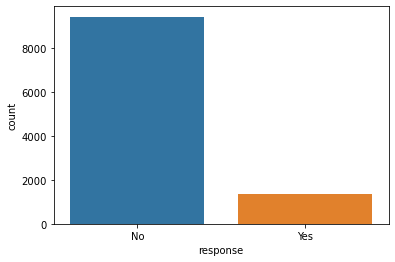

In [38]:
# Show a plot of the total number of responses.

sns.countplot(x=data['response'])

In [ ]:
# Show a plot of the response rate by the sales channel.

In [40]:
# For this, I need to make the response rate numerical:

data['response_numerical'] = data['response'].map(dict(Yes=1, No=0))

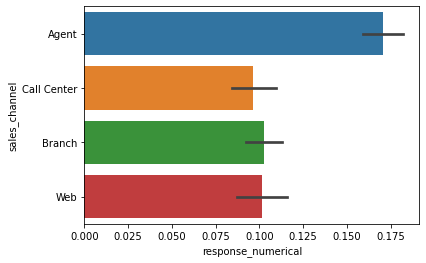

In [42]:
sns.barplot(x="response_numerical", y="sales_channel", data=data)
plt.show()

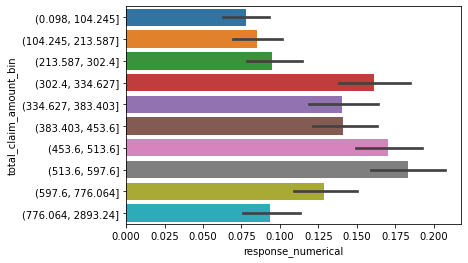

In [44]:
# Show a plot of the response rate by the total claim amount.

data['total_claim_amount_bin'] = pd.qcut(data['total_claim_amount'], q=10)

sns.barplot(x="response_numerical", y="total_claim_amount_bin", data=data)
plt.show()

# Here, I can quickly, on to go, adjust the amount of bins I want with "q= ", took 10 in this case.

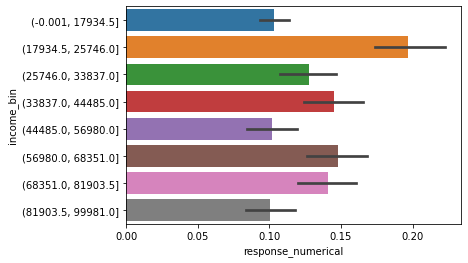

In [45]:
# Show a plot of the response rate by income.

data['income_bin'] = pd.qcut(data['income'], q=10, duplicates='drop')

sns.barplot(x="response_numerical", y="income_bin", data=data)
plt.show()

## REMINDER TO SELF: Better drop those bin columns (income_bin, total_claim_amount_bin) later. Also: The column(s) month or effective_to_date should be dropped since one is derived out of the other. 

# Round 4

Going to need some more libraries for this:

In [46]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

Check the data types of the columns. Get the numeric data into dataframe called numerical and categorical columns in a dataframe called categoricals. (You can use np.number and np.object to select the numerical data types and categorical data types respectively)

In [47]:
# Getting only numericals into the numerical dataframe

numerical = data.select_dtypes(include=np.number)
numerical

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount,month,response_numerical
0,4809.216960,48029,61,7.000000,52,0.000000,9,292.800000,2,0
1,2228.525238,0,64,3.000000,26,0.000000,1,744.924331,1,0
2,14947.917300,22139,100,34.000000,31,0.000000,2,480.000000,2,0
3,22332.439460,49078,97,10.000000,3,0.000000,2,484.013411,1,1
4,9025.067525,23675,117,15.146952,31,0.383926,7,707.925645,1,0
...,...,...,...,...,...,...,...,...,...,...
10905,15563.369440,0,253,15.146952,40,0.383926,7,1214.400000,1,0
10906,5259.444853,61146,65,7.000000,68,0.000000,6,273.018929,1,0
10907,23893.304100,39837,201,11.000000,63,0.000000,2,381.306996,2,0
10908,11971.977650,64195,158,0.000000,27,4.000000,6,618.288849,2,0


In [48]:
# Getting only categoricals into the categorical dataframe

categoricals = data.select_dtypes(include=['object'])
categoricals

,state,response,coverage,education,employmentstatus,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,vehicle_type
0,Arizona,No,Basic,College,Employed,M,Suburban,Married,Corporate Auto,Corporate L3,Offer3,Agent,Four-Door Car,Medsize,M
1,California,No,Basic,College,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer4,Call Center,Four-Door Car,Medsize,M
2,Washington,No,Basic,Bachelor,Employed,M,Suburban,Single,Personal Auto,Personal L3,Offer3,Call Center,SUV,Medsize,A
3,Oregon,Yes,Extended,College,Employed,M,Suburban,Single,Corporate Auto,Corporate L3,Offer2,Branch,Four-Door Car,Medsize,A
4,Oregon,No,Premium,Bachelor,Medical Leave,F,Suburban,Married,Personal Auto,Personal L2,Offer1,Branch,Four-Door Car,Medsize,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10905,Nevada,No,Premium,Bachelor,Unemployed,F,Suburban,Married,Personal Auto,Personal L1,Offer3,Web,Luxury Car,Medsize,A
10906,Oregon,No,Basic,College,Employed,F,Urban,Married,Personal Auto,Personal L3,Offer2,Branch,Four-Door Car,Medsize,A
10907,Arizona,No,Extended,Bachelor,Employed,F,Rural,Married,Corporate Auto,Corporate L3,Offer1,Web,Luxury SUV,Medsize,M
10908,California,No,Premium,College,Employed,F,Urban,Divorced,Personal Auto,Personal L1,Offer1,Branch,SUV,Medsize,A


Now we will try to check the normality of the numerical variables visually

    - Use seaborn library to construct distribution plots for the numerical variables
    - Use Matplotlib to construct histograms
    - Do the distributions for different numerical variables look like a normal distribution


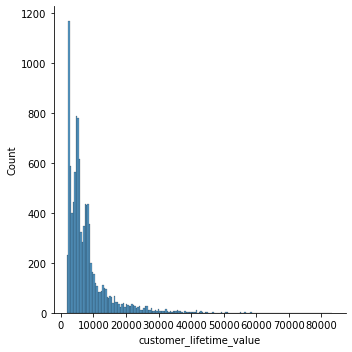

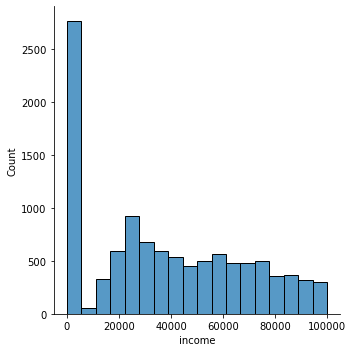

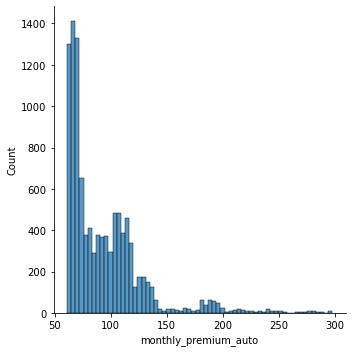

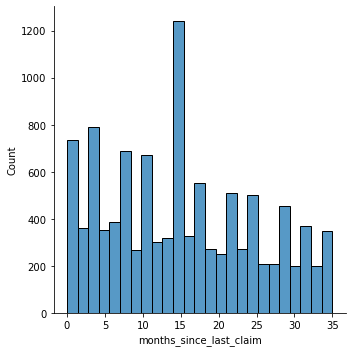

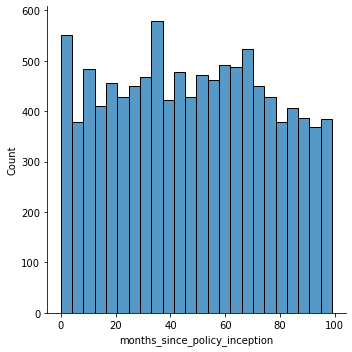

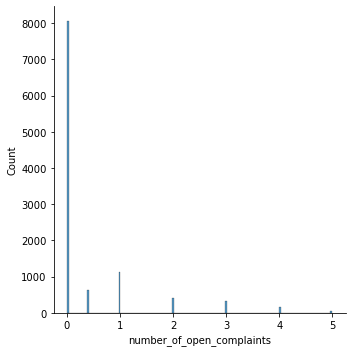

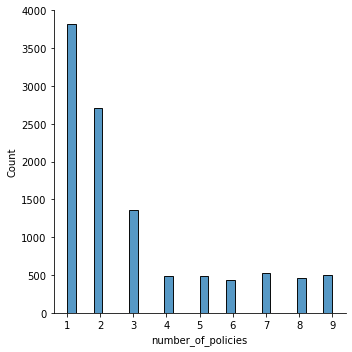

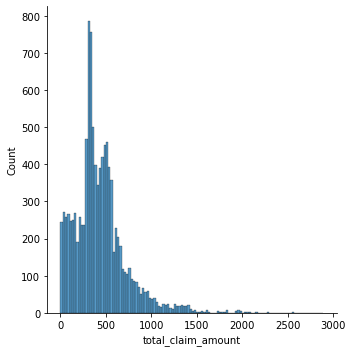

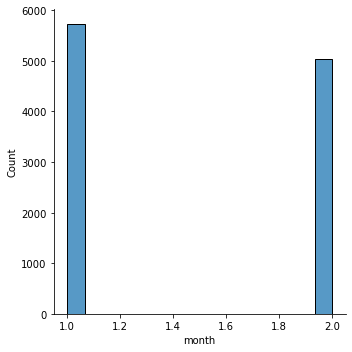

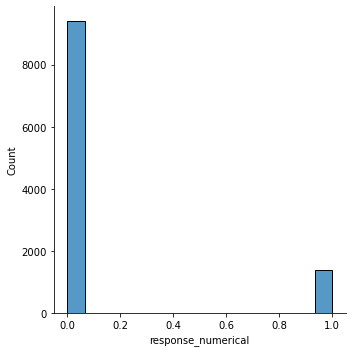

In [50]:
for column in numerical:
    sns.displot(numerical[column])

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'response_numerical'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

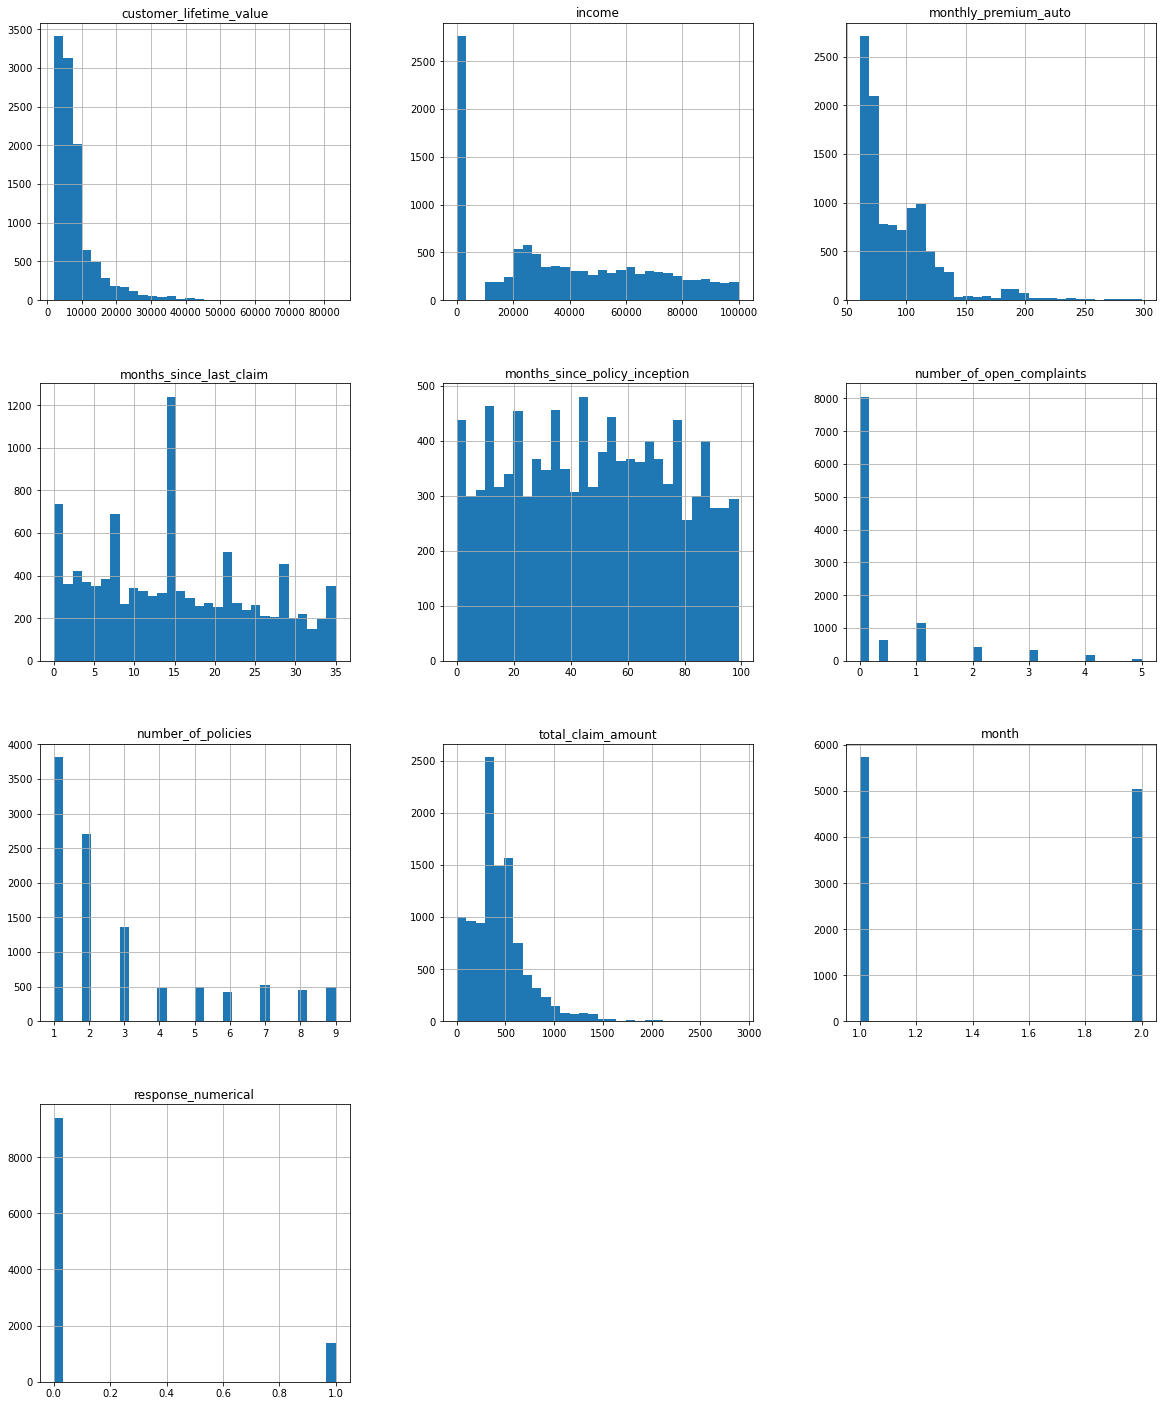

In [53]:
numerical.hist(bins=30, figsize=(20, 25))

#### For the numerical variables, check the multicollinearity between the features. Please note that we will use the column total_claim_amount later as the target variable.

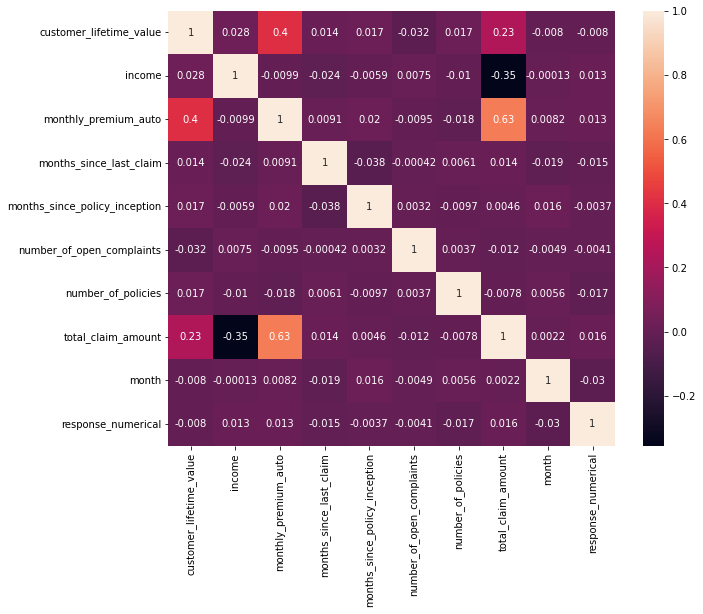

In [56]:
correlations_matrix = numerical.corr()

# Execute the display or print correlations_matrix alone if you want to see it without colour (less pretty imo)
correlations_matrix 

plt.figure(figsize = (10,8))
sns.heatmap(correlations_matrix, annot=True)
plt.show()

Pretty much no multicollinearity between the features

# Round 5

In [58]:
# Just doing this thing real quick, dropping response from categoricals because we already made it numerical:

categoricals = categoricals.drop('response', axis=1)

In [66]:
# Getting that cleaned data back together to have a nice starting point for the multiple regression:

df = pd.concat([categoricals, numerical], axis=1)
df.shape

(10776, 24)

#### X-y split

In [62]:
# Setting y to our target
y = df['total_claim_amount']
# Putting everything else to x
X = df.drop(['total_claim_amount'], axis=1)

#### Normalize (numerical)

In [63]:
# Splitting X into numericals and categoricals
X_num = X.select_dtypes(include=np.number)
X_cat = X.select_dtypes(include=['object'])
print(X_num.columns)
print(X_cat.columns)

Index(['customer_lifetime_value', 'income', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'month',
       'response_numerical'],
      dtype='object')
Index(['state', 'coverage', 'education', 'employmentstatus', 'gender',
       'location_code', 'marital_status', 'policy_type', 'policy',
       'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size',
       'vehicle_type'],
      dtype='object')


In [67]:
# Normalize between 0 and 1

MinMaxtransformer = MinMaxScaler().fit(X_num)
X_normalized = MinMaxtransformer.transform(X_num)
print(X_normalized.shape)
X_normalized = pd.DataFrame(X_normalized,columns=X_num.columns)
X_normalized.head()

(10776, 9)


,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,month,response_numerical
0,0.035752,0.480381,0.000000,0.200000,0.525253,0.000000,1.000,1.0,0.0
1,0.004059,0.000000,0.012658,0.085714,0.262626,0.000000,0.000,0.0,0.0
2,0.160264,0.221432,0.164557,0.971429,0.313131,0.000000,0.125,1.0,0.0
3,0.250953,0.490873,0.151899,0.285714,0.030303,0.000000,0.125,0.0,1.0
4,0.087527,0.236795,0.236287,0.432770,0.313131,0.076785,0.750,0.0,0.0


# Round 6

#### One Hot/Label Encoding (categorical).

In [69]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(X_cat)
encoded = encoder.transform(X_cat).toarray()
encoded
cols = encoder.get_feature_names_out(input_features=X_cat.columns)
cols

onehot_encoded = pd.DataFrame(encoded, columns=cols)
onehot_encoded

,state_California,state_Nevada,state_Oregon,state_Washington,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,education_Master,...,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small,vehicle_type_M
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10771,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10772,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10773,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
10774,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Concat DataFrames

In [79]:
X = pd.concat([X_normalized, onehot_encoded], axis=1)
X.head()

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,month,response_numerical,state_California,...,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small,vehicle_type_M
0,0.035752,0.480381,0.000000,0.200000,0.525253,0.000000,1.000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.004059,0.000000,0.012658,0.085714,0.262626,0.000000,0.000,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.160264,0.221432,0.164557,0.971429,0.313131,0.000000,0.125,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.250953,0.490873,0.151899,0.285714,0.030303,0.000000,0.125,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.087527,0.236795,0.236287,0.432770,0.313131,0.076785,0.750,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## Linear Regression

### Train-test split

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8620, 52)
(2156, 52)
(8620,)
(2156,)


In [82]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)


LinearRegression()

### Model Validation

##### R²

In [83]:
# Evaluation on training portion of data (the one used for training the model)
from sklearn.metrics import r2_score

predictions = lm.predict(X_train)
r2_score(y_train, predictions)

0.7736650375404899

In [85]:
# Evalution on test portion of data

predictions_test = lm.predict(X_test)
r2_score(y_test, predictions_test)

0.7604561847583473

##### MSE

In [86]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test,predictions_test)
mse

20146.07334144111

##### RMSE

In [87]:
rmse = np.sqrt(mean_squared_error(y_test,predictions_test))
rmse

141.9368639270331

##### MAE

In [89]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, predictions_test)
print(mae)

96.45539205822759
